In [2]:
import pandas as pd
import requests
import numpy as np

# Ï∂îÍ∞Ä Î∂ÑÏÑù Í≥ºÏ†ú

Ïö∞ÏôÅÍµ≥ÎãòÏùò ÏµúÏ†ÅÏùò ÎìÄÏò§Îäî ÎàÑÍµ¨ÏùºÍπå..!
ÌåÄÏö¥Ïù¥ ÎßéÏù¥ Ï†ÅÏö©ÎêòÎäî Í≤åÏûÑÏù¥Í∏¥ ÌïòÏßÄÎßå.. ÌòÑÏû¨ÍπåÏßÄ Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Î∞òÏúºÎ°ú ÏôÅÍµ≥ÎãòÍ≥ºÏùò  ÏãúÎÑàÏßÄÍ∞Ä Ï¢ãÏùÄ Î©§Î≤ÑÎ•º ÌÜµÍ≥ÑÏ†ÅÏúºÎ°ú ÌôïÏù∏Ìï¥Î≥¥Ïûê

* 15Î∂Ñ Ïù¥ÏÉÅ ÏßÑÌñâÎêú ÎØ∏ÎìúÎùºÏù¥ÎÑà Í≤ΩÍ∏∞

In [3]:
def get_puuid(summoner_name, api_key):
    # Get summoner puuid
    sohwan = "https://kr.api.riotgames.com/lol/summoner/v4/summoners/by-name/{}?api_key={}"
    url = sohwan.format(summoner_name, api_key)
    response = requests.get(url)
    puuid = response.json()['puuid']
    summoner_id = response.json()['id']
    iconId = response.json()['profileIconId']

    return puuid, summoner_id, iconId,


def get_match_ids(puuid, api_key, start= 0, count= 50):
    # Get match ids
    matchid_url = "https://asia.api.riotgames.com/lol/match/v5/matches/by-puuid/{}/ids?type=ranked&start={}&count={}&api_key={}"
    url = matchid_url.format(puuid, start, count, api_key)
    response = requests.get(url)
    match_ids = response.json()
    return match_ids


def get_match_data_logs(match_ids,api_key):
    # Get match data for each match id
    match_data_logs = []
    time_url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}/timeline?api_key={}'
    for i, match_id in enumerate(match_ids):
        url = time_url.format(match_id, api_key)
        response = requests.get(url)
        match_data_logs.append(pd.DataFrame(response.json()))

    return  match_data_logs


summoner_name = 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥'
#api_key= 'RGAPI-1d068ec6....'

puuid, summoner_id, iconId = get_puuid(summoner_name, api_key)
match_ids = get_match_ids(puuid, api_key, start= 0, count= 50)
match_data_logs = get_match_data_logs(match_ids, api_key)


In [ ]:
test = pd.concat(match_data_logs)

In [ ]:
test_id = match_ids[:5]

In [4]:
# match_v5 (Í≤ΩÍ∏∞Í∞Ä ÎÅùÎÇòÍ≥† ÎÇòÏò§Îäî ÌÜµÍ≥ÑÏöîÏïΩ)
def get_match_v5(match_ids, api_key):
    url = 'https://asia.api.riotgames.com/lol/match/v5/matches/{}?api_key={}'
    match_info_list = []
    champion_info_list = []

    for match_id in match_ids:
        response = requests.get(url.format(match_id, api_key))
        match_df = pd.DataFrame(response.json())

        try:
            df = pd.DataFrame(match_df['info']['participants'])
        except KeyError:
            print(f"KeyError: 'info' key not found in match_df for matchId {match_id}. Skipping...")
            continue

        sample = df[['teamId', 'puuid', 'summonerName', 'participantId', 'teamPosition', 'challenges', 'summoner1Id', 'summoner2Id',
            'championName', 'lane', 'kills', 'deaths', 'assists', 'totalMinionsKilled', 'neutralMinionsKilled', 'goldEarned', 'goldSpent', 'champExperience', 'item0', 'item1', 'item2',
            'item3', 'item4', 'item5', 'item6', 'totalDamageDealt', 'totalDamageDealtToChampions', 'totalDamageTaken', 'damageDealtToTurrets', 'damageDealtToBuildings',
            'totalTimeSpentDead', 'longestTimeSpentLiving', 'visionScore', 'win', 'timePlayed', 'damageSelfMitigated', 'totalDamageShieldedOnTeammates',
            'totalHealsOnTeammates', 'damageDealtToObjectives']]

        challenge = pd.DataFrame(sample['challenges'].tolist())

        col = challenge[['soloKills', 'multikills', 'abilityUses', 'damageTakenOnTeamPercentage', 'skillshotsDodged', 'skillshotsHit', 'enemyChampionImmobilizations', 'laneMinionsFirst10Minutes','controlWardsPlaced'
                        , 'visionScorePerMinute', 'wardTakedowns', 'effectiveHealAndShielding', 'dragonTakedowns', 'baronTakedowns', 'teamBaronKills']]
        jungle_and_etc_col = challenge.filter(regex='^jungle|Jungle|kda')

        match_info = pd.concat([sample, col, jungle_and_etc_col], axis=1)
        match_info['summonerName'] = match_info.apply(lambda row: row['puuid'][:10] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
        match_info['totalCS'] = match_info['totalMinionsKilled'] + match_info['neutralMinionsKilled']
        match_info['matchId'] = match_df['metadata']['matchId']
        match_info['championName'] = match_info['championName'].apply(lambda x: 'Fiddlesticks' if x == 'FiddleSticks' else x)  # ÌîºÎì§Ïä§Ìã± ÏóêÎü¨

        champion_info = match_info[['win','matchId', 'participantId', 'teamId', 'teamPosition', 'summonerName', 'puuid', 'championName']]

        match_info['win_kr'] = match_info['win'].apply(lambda x: 'ÏäπÎ¶¨' if x == 1 else 'Ìå®Î∞∞')
        match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

        # Í∞ÅÍ∞ÅÏùò Îç∞Ïù¥ÌÑ∞Î•º Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
        match_info_list.append(match_info)
        champion_info_list.append(champion_info)

        match_info = pd.concat(match_info_list)
        champion_info = pd.concat(champion_info_list)

    return match_info, champion_info


match_info, champion_info = get_match_v5(match_ids,api_key)


KeyError: 'info' key not found in match_df for matchId KR_6863866115. Skipping...


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

champion_info['matchId'].nunique()


50

In [ ]:
# 15Î∂Ñ Ï¥àÍ≥ºÏùò Í≤ΩÍ∏∞Îßå

def matchId_by_position (match_info, puuid ): # position
  match_info = match_info[(match_info['timePlayed'] > 900) & (match_info['puuid']==puuid) ] # & (match_info['teamPosition'] == position)
  matchId_list = match_info['matchId'].drop_duplicates().tolist()
  return matchId_list

matchId_list = matchId_by_position(match_info,puuid) # 48
match_info = match_info[match_info['matchId'].isin(matchId_list)]



In [ ]:
match_info['ti']

teamId                                              puuid summonerName  \
0     100  hSZ_GNCXzwhAl7tfk5gyj9HlxysceUJ8nPauPMCyWHaXv1...          Î∂ÑÏßÄÏö∏   
1     100  rYBYusOo6mZBaek7Zg_l12gDNuxT1PBSH5m9Agf6xY7Gzv...         ÌôòÎèåÏù¥Ïù¥   
2     100  9KSQywyOxFDCx7pd4XFnE7O9LlFfG1kpKKZxh0PvpxSMJk...     Ï∂©Ïã†Î≥ëÏûê ÏßÑÎìúÍ∏∞   
3     100  7tW5cFq9Au96KcE1mO-kfVsipVZCm_w8loMA8HcmOXosBX...      Î™®ÎãùÏ†ÑÎ¨∏ÌÑ∏Ïù¥Î≤î   
4     100  KGWDhY3WkA6EWU0gklon8NjuNICOfTWGbKnUmbgTCETAll...     rudgnsex   

   participantId teamPosition  \
0              1          TOP   
1              2       JUNGLE   
2              3       MIDDLE   
3              4       BOTTOM   
4              5      UTILITY   

                                          challenges  summoner1Id  \
0  {'12AssistStreakCount': 0, 'abilityUses': 91, ...           21   
1  {'12AssistStreakCount': 0, 'abilityUses': 638,...           11   
2  {'12AssistStreakCount': 0, 'abilityUses': 196,...           12   
3  {'12AssistStreakCount': 0, 'abilityUses': 318,...            1   
4  {'12AssistStreakCount': 0, 'abilityUses': 147,...           14   

   summoner2Id championName    lane  kills  deaths  assists  \
0            4      Warwick     TOP      0      12        5   
1            4        Talon  JUNGLE     10       4        4   
2            4    Lissandra  MIDDLE      5       8        5   
3            4       Ezreal  BOTTOM      7       8        3   
4            4        Swain  BOTTOM      2      11        7   

   totalMinionsKilled  neutralMinionsKilled  goldEarned  goldSpent  \
0                  77                     0        7308       8195   
1                  59                   155       16093      16000   
2                 152                     4       10477       9425   
3                 191                     0       12896      12383   
4                  15                     4        6639       6350   

   champExperience  item0  item1  item2  item3  item4  item5  item6  \
0            11909   3077   3111   6610   1054   1036      0   3340   
1            16955   6696   3156   3142   3158   6694   3026   3364   
2            12878   3118   2420   2055   4645   3020      0   3340   
3            11812   3158   2015   3086   3036   3042   3078   3363   
4             8790   1056   2150   6655   3118      0      0   3340   

   totalDamageDealt  totalDamageDealtToChampions  totalDamageTaken  \
0             48016                         5462             37618   
1            256828                        25851             32849   
2            101891                        13651             25463   
3            140809                        26491             23676   
4             34873                         9342             24488   

   damageDealtToTurrets  damageDealtToBuildings  totalTimeSpentDead  \
0                  1937                    1937                 317   
1                     0                       0                 129   
2                   413                     413                 318   
3                  5502                    5502                 165   
4                     0                       0                 236   

   longestTimeSpentLiving  visionScore    win  timePlayed  \
0                     373           18  False        1838   
1                     782           25  False        1838   
2                     893           20  False        1838   
3                     458           14  False        1838   
4                     299           10  False        1838   

   damageSelfMitigated  totalDamageShieldedOnTeammates  totalHealsOnTeammates  \
0                24226                               0                      0   
1                22748                               0                      0   
2                11126                               0                      0   
3                 8522                               0                      0   
4                 8719               

In [ ]:
match_info['totalCS10Minutes'] = match_info['laneMinionsFirst10Minutes'] + match_info['jungleCsBefore10Minutes']

In [ ]:
summoner_match_info = match_info[(match_info['puuid'] == puuid)] # &(match_info['teamPosition'] == 'MIDDLE')
other_line_info = match_info[(match_info['puuid'] != puuid)&(match_info['teamPosition'] == 'MIDDLE')]

team_line_info = (
    match_info.groupby(['matchId', 'teamId'])
      .filter(lambda x: any(x['summonerName'] == summoner_name))
)


In [ ]:
# Ï±îÌîºÏñ∏Î≥Ñ ÌÜµÍ≥Ñ
summoner_champ_static = summoner_match_info.groupby(['championName']).agg(
                        champion_count = pd.NamedAgg(column = 'championName', aggfunc='count'),
                        soloKills_sum = pd.NamedAgg(column = 'soloKills', aggfunc='sum'),
                        win_sum = pd.NamedAgg(column = 'win', aggfunc='sum'),
                        # timeplayed_mean = pd.NamedAgg(column = 'timePlayed', aggfunc='mean'),
                        totalCS10Minutes_mean = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean')).sort_values(by=['champion_count'], ascending=False).reset_index()
summoner_champ_static

championName  champion_count  soloKills_sum  win_sum  totalCS10Minutes_mean
0           Zed              13             31        6              52.692308
1          Azir               7              9        3              51.857143
2         Galio               4              2        3              55.250000
3      Katarina               4              7        1              47.750000
4        Ezreal               3              0        2              47.333333
5          Hwei               3              4        1              60.333333
6         Akali               2              0        0              47.500000
7       Caitlyn               2              2        2              51.000000
8       Morgana               2              4        1              55.500000
9           Zoe               2              0        1              49.000000
10         Ahri               1              0        1              49.000000
11         Ashe               1              0        0              48.000000
12     Pantheon               1              7        0              63.000000
13          Vex               1              0        0              51.000000
14         Yone               1              1        0              52.000000

In [ ]:
champion_info

In [ ]:
# 'Ïö∞ÏπòÌïò ÌûàÌÇ§ÌÇπ','Ïö∞ÏôÅÍµ≥', 'Ï§Ä99'
hiki_king_matchids = champion_info[champion_info['summonerName'] == 'Ïö∞ÏπòÌïò ÌûàÌÇ§ÌÇπ']['matchId'].tolist()
chunyang_matchids = champion_info[champion_info['summonerName'] == 'Ïö∞ÏôÅÍµ≥']['matchId'].tolist()
jun99_matchids = champion_info[champion_info['summonerName'] == 'Ï§Ä99']['matchId'].tolist()
Nollan_matchIds = champion_info[champion_info['summonerName'] == 'The Nollan']['matchId'].tolist()

Nollan_matchIds

In [ ]:
# Ïú†Ï†ÄÏùò Îû≠ÌÅ¨ , ÏäπÌå®
def get_rank_info (summoner_id, api_key):
    rank_info = "https://kr.api.riotgames.com/lol/league/v4/entries/by-summoner/{}?api_key={}"
    url = rank_info.format(summoner_id, api_key)
    response = requests.get(url)
    rank_data = response.json()

    return rank_data


rank_data = get_rank_info(summoner_id,api_key)
rank_data

[{'leagueId': '938c6c81-8a9f-46bd-82da-44d0d066bb6e',
  'queueType': 'RANKED_SOLO_5x5',
  'tier': 'IRON',
  'rank': 'III',
  'summonerId': 'BpLMTYwLBEmcLZCK9QCYNJxtFss7bvN0GSTlb6TJ55Bpjcc',
  'summonerName': 'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥',
  'leaguePoints': 0,
  'wins': 7,
  'losses': 11,
  'veteran': False,
  'inactive': False,
  'freshBlood': True,
  'hotStreak': False}]

### ÏµúÍ∑º 20Í≤ΩÍ∏∞ ÏßÄÌëú (ÌèâÍ∑†)
* ÏÉÅÎåÄÎùºÏù¥ÎÑà Í∏∞Ï§Ä
* ÌåÄÏõê ÌèâÍ∑† Í∏∞Ï§Ä


In [5]:
match_info['timePlayed'] = match_info['timePlayed']/60

In [18]:
# len(match_info[(match_info['timePlayed'] < 35) & (match_info['timePlayed'] > 14)]['matchId'].unique())

len(match_info[match_info['timePlayed'] > 15]['matchId'].unique())

# import seaborn as sns

# # Î∂ÑÌè¨ ÌôïÏù∏
# fig, ax = plt.subplots(nrows=1, figsize=(8,5))
# sns.distplot(match_info['timePlayed'], hist=False)
# plt.subplots_adjust(hspace=1)
# plt.show()



46

In [ ]:
# ÏôÅÍµ≥ÎãòÏùò ÎåÄÌëú Í≤åÏûÑÏßÄÌëú (ÌèâÍ∑†)
wak_score = summoner_match_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                    'totalDamageDealtToChampions','damageDealtToBuildings']]
opponent_score = other_line_info[['summonerName','visionScore','soloKills','totalCS10Minutes',
                        'totalDamageDealtToChampions','damageDealtToBuildings']]

wak_vs_df = pd.concat([wak_score,opponent_score])
wak_vs_df.loc[wak_vs_df['summonerName']!= summoner_name, 'summonerName'] = 'ÏÉÅÎåÄÎùºÏù¥ÎÑà'


normalization_df = (wak_vs_df - wak_vs_df.min(numeric_only=True))/(wak_vs_df.max(numeric_only=True) - wak_vs_df.min(numeric_only=True))
normalization_df['summonerName'] = wak_vs_df['summonerName']

z = normalization_df.groupby(['summonerName']).agg(
      totalDamageDealtToChampions= pd.NamedAgg(column = 'totalDamageDealtToChampions', aggfunc='mean'),
      totalCS10Minutes = pd.NamedAgg(column = 'totalCS10Minutes', aggfunc='mean'),
      soloKills = pd.NamedAgg(column = 'soloKills', aggfunc='mean'),
      visionScore = pd.NamedAgg(column = 'visionScore', aggfunc='mean'),
      damageDealtToBuildings = pd.NamedAgg(column = 'damageDealtToBuildings', aggfunc='mean'),
).reset_index()


melted_df = pd.melt(z, id_vars=["summonerName"], var_name="var", value_name="value")
pivoted_df = melted_df.pivot(index="var", columns="summonerName", values="value").reset_index()
radar_data = pivoted_df.to_dict("records")

radar_data

[{'var': 'damageDealtToBuildings',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.21760340842022427,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.2368426160056783},
 {'var': 'soloKills',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.11956521739130435,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.23692810457516342},
 {'var': 'totalCS10Minutes',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.4107142857142857,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.5777310924369748},
 {'var': 'totalDamageDealtToChampions',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.3366015916100501,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.3535148577133843},
 {'var': 'visionScore',
  'Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥': 0.40084835630965004,
  'ÏÉÅÎåÄÎùºÏù¥ÎÑà': 0.42324246771879487}]

### Ïö∞ÏôÅÍµ≥ÎãòÏùò Ï£ºÏöî ÎùºÏù∏ Î∞è Ï±îÌîºÏñ∏

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt

print(summoner_match_info['teamPosition'].value_counts())
print(summoner_match_info['championName'].value_counts())

MIDDLE    41
BOTTOM     5
Name: teamPosition, dtype: int64
Zed         15
Azir         6
Galio        4
Morgana      3
Katarina     3
Caitlyn      2
Ezreal       2
Zoe          2
Akali        2
Hwei         2
Ashe         1
Ahri         1
Pantheon     1
Yone         1
Vex          1
Name: championName, dtype: int64


In [ ]:
summoner_match_info

## (Í≥µÌÜµ) death Í¥ÄÎ†® ÏßÄÌëú

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Ïùò Í≥®Îìú Ï∞®Ïù¥Î•º Î∂ÑÏÑùÌï¥Î≥¥

In [ ]:
df = pd.concat(match_data_logs)
t = df[df['status'].isna()]
match_ids = t['metadata']['matchId'].tolist()
match_ids

In [ ]:
match_data_logs

In [ ]:
def get_events(match_data_logs):
    all_events_list = []  # Ï≤´Î≤àÏß∏ Îß§ÏπòÎ∂ÄÌÑ∞ nÎ≤àÏß∏ Îß§ÏπòÍπåÏßÄ
    position_logs_list = []

    for match_data_log in match_data_logs:
        matchId = match_data_log['metadata']['matchId']
        frame_df = pd.DataFrame(match_data_log['info']['frames'])
        events_df = pd.DataFrame(frame_df['events'])
        events = events_df['events'].tolist()

        events_all_participant_ids = []

        for event in events:
            for event_dict in event:
                event_dict['matchId'] = matchId  # matchIdÎ•º Í∞Å Ïù¥Î≤§Ìä∏Ïóê Ï∂îÍ∞Ä
                events_all_participant_ids.append(event_dict)

        all_events = pd.DataFrame(events_all_participant_ids)

        # Í≤åÏûÑÏù¥ Ï∑®ÏÜåÎêú Í≤ΩÏö∞ Ïª¨ÎüºÏù¥ ÏóÜÏùå
        required_columns = ['timestamp', 'type', 'position', 'teamId', 'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']
        if all(column in all_events.columns for column in required_columns):
            df = all_events[(all_events['type'] == 'CHAMPION_KILL') | (all_events['type'] == 'ELITE_MONSTER_KILL') | (all_events['type'] == 'BUILDING_KILL')]
            position_logs = df[['timestamp', 'type', 'position', 'teamId', 'killerId', 'victimId', 'assistingParticipantIds','victimDamageDealt','victimDamageReceived', 'matchId']]
            position_logs_list.append(position_logs)
        else:
            print(f"Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî {matchId}. Skip.")

        all_events_list.append(all_events)

    return all_events_list, position_logs_list

# Assuming match_data_logs is provided
all_events_list, position_logs_list = get_events(match_data_logs)



Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî KR_6900203193. Skip.
Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî KR_6895792750. Skip.
Ï∑®ÏÜåÎêú Îß§ÏπòÏïÑÏù¥Îîî KR_6877700906. Skip.


In [ ]:
# Ï±îÌîºÏñ∏ÌÇ¨Ïóê ÎåÄÌïú Î°úÍ∑∏
position_logs = pd.concat(position_logs_list)
kill_log = position_logs[position_logs['type'] == 'CHAMPION_KILL']
kill_log['timestamp'] = kill_log['timestamp']/60000

<ipython-input-37-ac232351861d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kill_log['timestamp'] = kill_log['timestamp']/60000


In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Ï±îÌîºÏñ∏ Ï∞∏Í∞ÄÏûê ÏïÑÏù¥Îîî Ï†ïÎ≥¥
champion_info = champion_info[['matchId','teamId','participantId','summonerName','championName','teamPosition','win']]
info = champion_info.copy()


In [ ]:
champion_info

### Summoner Death Table

In [ ]:
info['victimId'] = info['participantId']
info['killerId'] = info['participantId']

In [ ]:
# Ìï¥Îãπ ÏÜåÌôòÏÇ¨Ïùò matchidÎ≥Ñ partcipantId
wak_participantId = info.loc[(info['summonerName'] == summoner_name) & (info['win']== False) , ['matchId' ,'victimId']]
lose_matchlist = info[(info['summonerName'] == summoner_name) & (info['win']== False)]['matchId'].tolist()


In [ ]:
# ÏÜåÌôòÏÇ¨Ïùò ÌåÄ Ï†ïÎ≥¥ (ÏßÑÍ≤ΩÍ∏∞)
lose_game_info = info[(info['matchId'].isin(lose_matchlist)) & (info['win'] == False)]

In [ ]:
lose_game_info

In [ ]:
# Ìï¥Îãπ ÏÜåÌôòÏÇ¨ ÌåÄÏùò Îç∞Ïä§Î°úÍ∑∏ (ÏßÑÍ≤ΩÍ∏∞)
wakteam_death_log = pd.merge(kill_log, lose_game_info, on =['matchId','victimId'], how = 'inner')

# Ìï¥Îãπ ÏÜåÌôòÏÇ¨Ïùò Îç∞Ïä§Î°úÍ∑∏ (Î™®Îì†Í≤ΩÍ∏∞)
wak_death_log = pd.merge(kill_log, wak_participantId, on=['matchId', 'victimId'], how='inner')

In [ ]:
wak_death_solo = wak_death_log[wak_death_log['assistingParticipantIds'].isna()] # Îã§Î•∏ ÏÉÅÎåÄÌåÄÏùò Ïñ¥ÏãúÏä§Ìä∏ ÏóÜÏù¥ ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞
wak_death_gang = wak_death_log[~wak_death_log['assistingParticipantIds'].isna()] # Îã§Î•∏ ÏÉÅÎåÄÌåÄÍ≥º Ìï®Íªò ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞

len(wak_death_gang)

142

In [ ]:
wakteam_death_log.head()

In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ ÎùºÏù∏Ï†ÑÎèôÏïà deathÌïú ÌöüÏàò
team_death_15 = wakteam_death_log[wakteam_death_log['timestamp'] < 16].groupby(['teamPosition']).agg(
                count = pd.NamedAgg(column = 'teamPosition', aggfunc='count')
                ).reset_index()

team_death_15

teamPosition  count
0       BOTTOM     79
1       JUNGLE     74
2       MIDDLE     67
3          TOP     74
4      UTILITY     84

In [ ]:
# to json
death_cnt = []
for index, row in team_death_15.iterrows():
    item = {
        'x': row["teamPosition"],
        'y': row["count"]
    }
    death_cnt.append(item)


death_cnt

[{'x': 'BOTTOM', 'y': 79},
 {'x': 'JUNGLE', 'y': 74},
 {'x': 'MIDDLE', 'y': 67},
 {'x': 'TOP', 'y': 74},
 {'x': 'UTILITY', 'y': 84}]

> * 15Î∂ÑÏù¥Ï†ÑÍ≥º 15Î∂Ñ Ïù¥ÌõÑÎ°ú ÎÇòÎà†ÏÑú Ïñ∏Ï†ú ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïòÎäîÏßÄ Î¥êÎèÑ Ï¢ãÏùÑÎìØ
* Ï£ºÎ°ú Ï£ΩÎäî ÏúÑÏπò
* ÏÜîÎ°úÌÇ¨Í≥º ÏÉÅÎåÄÎ∞©Ïùò Í∞úÏûÖÏóê Ï£ΩÎäî ÌöüÏàò
* ÏÉÅÎåÄÎ∞© Í∞úÏûÖÏóê Ï£ΩÎäî Îã§Î©¥ Ï£ºÎ°ú ÎàÑÍµ¨ÏóêÍ≤å Ï£ΩÎäîÍ∞Ä (ÎùºÏù∏Ï†Ñ)


### 15Î∂Ñ Ïù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ ÌîºÌï¥ÎüâÏùÑ Î∞õÏùÄ Ìè¨ÏßÄÏÖòÏùÄ?

In [ ]:
wakteam_death_log.head()

In [ ]:
death_list = []
if not wakteam_death_log.empty:
    for d, ts, id, vicitmId in zip(wakteam_death_log['victimDamageReceived'], wakteam_death_log['timestamp'],wakteam_death_log['matchId'],wakteam_death_log['victimId']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['victimId'] = vicitmId
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage','victimId'])



In [ ]:
death_damage_log['victimId'] = death_damage_log['victimId'].astype(int)

In [ ]:
death_damage_log.head()

matchId  timestamp  victimId    championName  totalDamage
0  KR_6905620840   2.996367        10  Minion/Monster            8
1  KR_6905620840   2.996367        10  Minion/Monster           60
2  KR_6905620840   2.996367        10  Minion/Monster           22
3  KR_6905620840   2.996367        10  Minion/Monster           35
4  KR_6905620840   2.996367        10          Xerath           42

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Ï±îÌîºÏñ∏,Ìè¨ÏßÄÏÖò Ï†ïÎ≥¥ Í≤∞Ìï©
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','victimId','totalDamage']
death_damage_log = death_damage_log[['matchId','timestamp','victimId','championName','totalDamage']]

In [ ]:
# ÎùºÏù∏Ï†Ñ Î∞õÏùÄ ÌîºÌï¥Îüâ

death_15 = death_damage_log[death_damage_log['timestamp']< 16]

t = pd.merge(death_15, lose_game_info, on=['matchId', 'victimId'], how='inner')[['matchId','timestamp','teamPosition','victimId','totalDamage']]
t.head()


In [ ]:
taken_damage_15 = t.groupby(['teamPosition']).agg({'totalDamage':'sum'})
taken_damage_15

totalDamage
teamPosition             
BOTTOM              84224
JUNGLE              89792
MIDDLE              72239
TOP                 98946
UTILITY             81414

### ÏÉÅÎåÄÎ∞©Ïùò Í∞úÏûÖÏóêÏùòÌï¥ Ï£ΩÎäî Í≤ΩÏö∞

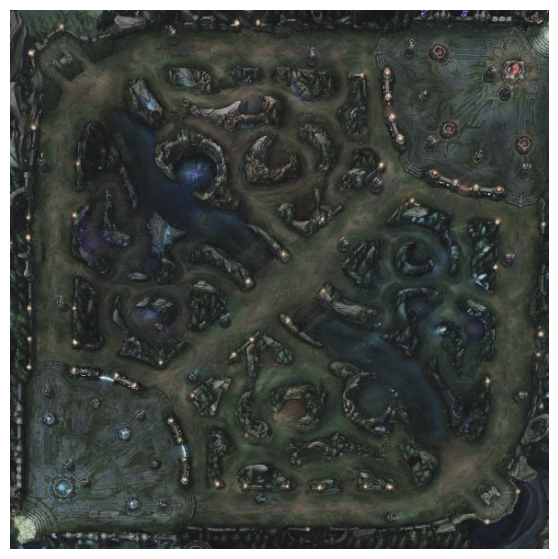

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
plt.axis('off')

# Add image of map
map_path = "/content/black_map.jpg"
img = Image.open(map_path)
ax.imshow(img, extent=[0, 15000, 0, 15000])

In [ ]:
# Î¶¨Ïä§Ìä∏Ïóê ÌíÄÍ≥† concat Ìï¥ÏÑú dataframeÏúºÎ°ú
death_list = []

for damage_list in wak_death_gang['victimDamageReceived']: # wak_death_gang['victimDamageReceived'] Í∞ÅÌñâÏùÑ Î£®ÌîÑ
    for damage_dict in damage_list: # Í∞ÅÌñâ ÏïàÏóêÏûàÎäî dict Í∞íÎì§ÏùÑ Î£®ÌîÑ
        df = pd.json_normalize(damage_dict) # dict Í∞íÏùÑ Ï†ïÍ∑úÌôî (jsonÏùÑ Ìë∏Îäî)
        death_list.append(df) # Î™®Îëê Í≤∞Ìï©

result_df = pd.concat(death_list, ignore_index=True)


In [ ]:
# ÎÇ¥Í∞Ä Í∞±Ïóê ÏùòÌï¥ Ï£ΩÏùÄÍ≤ΩÏö∞ Î∞õÏùÄ ÌîºÌï¥ÎüâÏùÑ ÌôïÏù∏ÌïúÎã§.
# wak_death_gang

death_list = []
if not wak_death_gang.empty:
    for d, ts, id in zip(wak_death_gang['victimDamageReceived'], wak_death_gang['timestamp'],wak_death_gang['matchId']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])



matchId  timestamp    name  participantId      spellName  \
0  KR_6893477121   17.93075  Samira              9  samirapassive   
1  KR_6893477121   17.93075  Samira              9  samirapassive   
2  KR_6893477121   17.93075  Samira              9        samirae   
3  KR_6893477121   17.93075  Samira              9        samiraq   
4  KR_6893477121   17.93075  Samira              9                  

   magicDamage  physicalDamage  trueDamage  
0           11             142           0  
1            0              84           0  
2           43               0           0  
3           10             302           0  
4            0              24           0

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Ï±îÌîºÏñ∏,Ìè¨ÏßÄÏÖò Ï†ïÎ≥¥ Í≤∞Ìï©
death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage']+ death_damage_log['trueDamage']
death_damage_log.columns = ['matchId','timestamp','championName','participantId','spellName','magicDamage','physicalDamage','trueDamage','totalDamage']
death_damage_log = pd.merge(death_damage_log, champion_info, on=['matchId', 'participantId','championName'], how='inner').drop(['victimId','killerId'],axis=1)
death_damage_log

In [ ]:
# 15Î∂Ñ Ïù¥Ï†Ñ, Ïñ¥Îñ§ Ìè¨ÏßÄÏÖòÏóê ÏùòÌï¥ Í∞ÄÏû• ÎßéÏù¥ Ï£ΩÏóàÏùÑÍπå?
death_before_15 = death_damage_log[death_damage_log['timestamp'] < 15]

In [ ]:
death_before_15

In [ ]:
# Í∞ôÏùÄ ÎùºÏù¥ÎÑàÏù∏ MIDDLE ÏùÑ Ï†úÏô∏ÌïòÎ©¥ JUNGLE Ïùò Í∞úÏûÖÏùÑ ÎßéÏù¥ Î∞õÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

group_by_position = death_before_15.groupby(['teamPosition']).agg(
    totalDamage = pd.NamedAgg(column = 'totalDamage', aggfunc= 'sum'),
    totalCnt = pd.NamedAgg(column = 'teamPosition',aggfunc = 'count')
    ).reset_index()

group_by_position[['teamPosition','totalDamage','totalCnt']].style.background_gradient(cmap='Blues')

### ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïú Í≤ΩÏö∞


ÎùºÏù∏Ï†Ñ Ï†ÑÌõÑÎ°ú Ïñ∏Ï†ú ÏÜîÎ°úÌÇ¨ÏùÑ Í∞ÄÏû• ÎßéÏù¥ ÎãπÌñàÏùÑÍπå?

In [ ]:
wak_death_solo['group'] = 1
wak_death_solo.loc[wak_death_solo['timestamp'] >= 15, 'group'] = 2


<ipython-input-74-db4382886423>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wak_death_solo['group'] = 1


In [ ]:
wak_death_solo['group'].value_counts()

2    51
1    37
Name: group, dtype: int64

damm.. ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑÏóê ÏûòÎ¶¨Îäî Í≤ΩÏö∞Í∞Ä ÏõîÎì±Ìûà ÎçîÎßéÎã§

* Í∑∏Î†áÎã§Î©¥ ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑÏóêÎäî Ï£ºÎ°ú Ïñ¥ÎîîÏÑú ÏûòÎ¶¨Îäî Í±∏Íπå?

In [ ]:
# ÎùºÏù∏ÏùÑ Î®∏Î¨∏ Ï†êÏàò Í≥ÑÏÇ∞
def calculate_lane(x, y):
    top_ranges = [(500, 2000, 6000, 14000),(600, 9000, 13000, 14500), (1900,4500,11100,13100)]

    bottom_ranges = [(6000, 14000, 500, 2000),(13000,14500, 500,9000),(10500,13000,2000,3800)]

    mid_ranges = [(4500, 6000, 4500, 6000),(5200,6700,5200,6700),(5900,7400,5900,7400),(6000,8500,6000,8500),
                  (7300,8800,7300,8800),(8000,9500,8000,9500),(8700,10200,8700,10200),(9200,10500,9200,10500)]

    blue_zone = [(0,4500,0,4500)]
    red_zone = [(10500,15000,10500,15000)]

    for range_ in top_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'top'
    for range_ in mid_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'mid'
    for range_ in bottom_ranges:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'bottom'
    for range_ in blue_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'blue_zone'
    for range_ in red_zone:
        if range_[0] <= x <= range_[1] and range_[2] <= y <= range_[3]:
            return 'red_zone'
    return 'jungle' # ÎÇòÎ®∏ÏßÄÎäî jungle


In [ ]:
wak_death_solo.loc[:, 'lane'] = wak_death_solo.apply(lambda row: calculate_lane(row['position']['x'], row['position']['y']), axis=1)
wak_death_solo

* Ï¢åÌëúÎ•º Î®ºÏ†Ä ÏãúÍ∞ÅÌôîÌï¥Î≥¥Ïûê
* ÏïÑÎûòÎäî 15Î∂Ñ Ïù¥ÌõÑ ÏÜîÎ°úÌÇ¨Î°ú ÏûòÎ¶∞ Í≤ΩÏö∞Ïù¥Îã§.
> ÌäπÌûà, Î∞îÌÖÄÎùºÏù∏ÏóêÏÑú Ïß§Î¶¨Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§. ÏïÑÎ¨¥ÎûòÎèÑ ÎùºÏù∏Ï†Ñ(ÎØ∏Îìú) Ïù¥ÌõÑ Î∞îÌÖÄÎùºÏù∏Í≥º Ïä§ÏôëÌïòÍ≥† ÏÇ¨Ïù¥ÎìúÎ•º ÎØ∏Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÎç∞, Ïù¥ Îïå ÌëúÏ†ÅÏù¥ ÎêòÍ∏∞ ÏâΩÎã§.

In [ ]:
df = wak_death_solo[wak_death_solo['group'] == 2]

In [ ]:
df['lane'].value_counts()

bottom       20
jungle       13
mid           7
blue_zone     5
top           4
red_zone      2
Name: lane, dtype: int64

In [ ]:
df[['timestamp','position']]

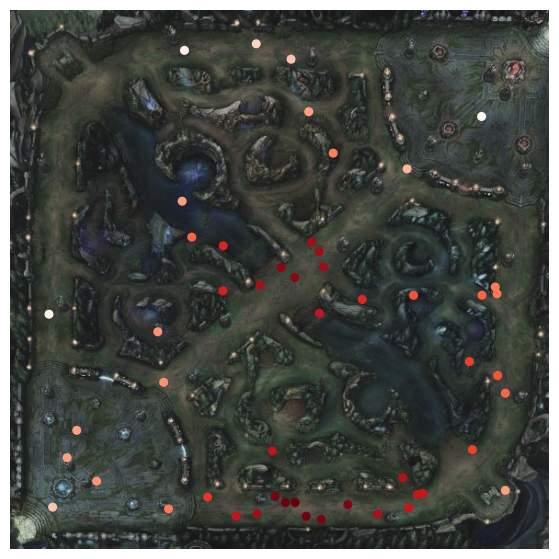

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde


# Ï¢åÌëú Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
x_data = df['position'].apply(lambda pos: pos['x'])
y_data = df['position'].apply(lambda pos: pos['y'])

# Î∞ÄÎèÑ ÌîåÎ°ØÏùÑ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

# Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(0, 15000)
ax.set_ylim(0, 15000)
plt.axis('off')

# ÏßÄÎèÑ Ïù¥ÎØ∏ÏßÄ Ï∂îÍ∞Ä
map_path = "/content/black_map.jpg"
img = Image.open(map_path)
ax.imshow(img, extent=[0, 15000, 0, 15000])

# Î∞ÄÎèÑ ÌîåÎ°ØÏúºÎ°ú ÌëúÏãú
sc = ax.scatter(x_data, y_data, c=z, cmap='Reds', s=30)


# colorbar Ï∂îÍ∞Ä
cbar = plt.colorbar(sc)
cbar.set_label('Density')
cbar.remove()

plt.show()


(15Î∂Ñ Ïù¥ÌõÑ) ÎØ∏ÎìúÎùºÏù¥ÎÑàÏùò Í≤ΩÏö∞ ÎùºÏù∏Ï†ÑÏù¥ ÎÅùÎÇòÍ≥† ÏÇ¨Ïù¥ÎìúÎ•º ÎØ∏Îäî Í≤ΩÏö∞Í∞Ä ÎßéÎã§. Ìï¥Îãπ summoner ÎòêÌïú Î∞îÌÖÄÏù¥ÎÇò Ï†ïÍ∏ÄÏßÄÏó≠ÏóêÏÑú Ïß§Î¶¨Îäî Í≤ΩÏö∞Í∞Ä ÎßéÏùÄÍ≤ÉÏùÑ Î≥º Ïàò ÏûàÎã§.

In [ ]:
from PIL import Image, ImageDraw,ImageEnhance

version = '13.24.1'
champion_url = f"http://ddragon.leagueoflegends.com/cdn/{version}/img/profileicon/{iconId}.png"
response = requests.get(champion_url)
img = Image.open(BytesIO(response.content))


mask = Image.new("L", img.size, 0)
draw = ImageDraw.Draw(mask)
draw.ellipse((0, 0) + img.size, fill=255)
img.putalpha(mask)
# ÌÅ¨Í∏∞ Ï°∞Ï†à
icon = img.resize((50, 50))

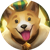

In [ ]:
icon

# üíª Í∂ÅÍ∏àÌïúÍ≤å Î≠òÍπå..?
Ï±îÌîºÏñ∏Î≥ÑÎ°ú Î¥êÏïºÌï†Íπå.. Ìè¨ÏßÄÏÖòÎ≥ÑÎ°ú Î¥êÏïºÌï†Íπå.. ÎëòÎã§Î≥¥Ïûê! \

Ïö∞ÏôÅÍµ≥ vs Ïó¨ÌÉúÍπåÏßÄ ÎßåÎÇú ÎØ∏ÎìúÎùºÏù¥ÎÑà

## ‚úîÔ∏è Ìï¥Îãπ summonerÏóê ÎåÄÌïú Î∂ÑÏÑù
### ‚ë† Ïó¨ÌÉúÍπåÏßÄ ÎßåÎÇú Ïú†Ï†ÄÎì§Í≥ºÏùò Í∏∞Î≥∏Ï†ÅÏù∏ ÏßÄÌëúÎπÑÍµê
* ÏÉÅÎåÄÎùºÏù¥ÎÑàÏôÄ ÎπÑÍµê
* ÌåÄÏõêÌèâÍ∑†Í≥º ÎπÑÍµê
* ÏÉÅÎåÄÌèâÍ∑†Í≥º ÎπÑÍµê

### ‚ë° Ïôú Ï£ΩÏùÄ Í±∏Í∞Ä? death ÏôÄ Í¥ÄÎ†®Îêú ÏßÄÌëú
* ÎùºÏù∏Ï†Ñ ÎèôÏïà Ï£ΩÏùÄ Í≤ΩÏö∞, Í∞ÄÏû• Í∞úÏûÖÏù¥ ÎßéÏïòÎçò ÏÉÅÎåÄ Ìè¨ÏßÄÏÖòÏùÄ ÎàÑÍµ¨ÏùºÍπå?
* (ÏÜîÎ°úÌÇ¨ÏùÑ ÎãπÌïúÍ≤ΩÏö∞) ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑ ÎÇòÎäî Ïñ¥ÎîîÏÑú Ïß§Î¶¨Îäî Í±∏Íπå?

### ‚ë¢ Ïôú ÏßÑÍ±∏Íπå? (Î∂ÄÏ†ú: ÎàÑÍ∞Ä Ï£ÑÏù∏Ïù∏Í∞Ä )
* ÎßåÏïΩ Ï°åÎã§Î©¥ Ïñ¥ÎäêÎùºÏù∏Ïù¥ ÌÑ∞Ï†∏ÏÑú ÏßÑÍ±∏Íπå?
* Ï¥àÎ∞òÍ≥º ÌõÑÎ∞òÏúºÎ°ú ÎÇòÎà†ÏÑú Î∂ÑÏÑùÌï† Ïàò ÏûàÏùå
* ÎåÄÌëúÏ†ÅÏù∏ ÏßÄÌëúÎ°ú death Î°úÍ∑∏ÏôÄ gold Ï∞®Ïù¥Î•º Î∂ÑÏÑùÌïòÎ©¥ Îê†Í≤ÉÍ∞ôÎã§
* Ï§ëÍ∞ÑÏóê Í≤åÏûÑÏùÑ Ìè¨Í∏∞ÌïòÍ≥† ÎÇòÍ∞Ñ Í≤ΩÏö∞ÎèÑ ÏûàÏùå  (Ïù¥ Í≤ΩÏö∞ ÌÉàÏ£ºÌïú ÌåÄÏõêÏùÑ ÎßåÎÇú ÌöüÏàòÎ•º Ï∂îÍ∞Ä)


> Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ÏóêÏÑú Í∞Å Îß§ÏπòÎ≥ÑÎ°ú 15Î∂ÑÏ†ÑÌõÑ ÏùºÏñ¥ÎÇú Îç∞Ïä§Î°úÍ∑∏ÏôÄ Í∑∏Ïóê Îî∞Î•∏ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä Ïñ¥ÎäêÏ†ïÎèÑ ÎÇòÌÉÄÎÇòÎäîÏßÄ, Í∑∏ÎûòÏÑú Ïñ¥Îñ§ ÎùºÏù∏Ïóê ÏùòÌï¥ Í≤åÏûÑÏù¥ ÌÑ∞Ï°åÎäîÏßÄ ÌôïÏù∏Ìï¥Î≥º Ïàò ÏûàÎã§!

### ‚ë£ ÌòÑÏû¨ÍπåÏßÄ Ìï©Ïù¥ ÏûòÎßûÎäî ÎìÄÏò§Îäî ÎàÑÍµ¨ÏùºÍπå?
> Ìï©Ïù¥ ÏûòÎßûÎã§Îäî Í∏∞Ï§ÄÏùÑ Î¨¥ÏóáÏúºÎ°ú Î≥ºÍ≤ÉÏù∏Í∞Ä
* Í∏∞Î≥∏Ï†ÅÏù∏ ÏßÄÌëú, ÎùºÏù∏Ï†Ñ Ï∫êÎ¶¨Î†•, ÌïúÌÉÄ Ï∫êÎ¶¨Î†•, ÌòÑÏû¨ÍπåÏßÄÏùò ÏäπÎ•†
* summoner ÏôÄ ÏÉÅÌò∏ÏûëÏö©ÏùÑ ÌÜµÌï¥ Í∞ÄÏû• ÎßéÏùÄ kill,assist ÏÑ±Í≥ºÎ•º Îã¨ÏÑ±Ìïú Î©§Î≤Ñ?

---

## üìä ÎåÄÏãúÎ≥¥Îìú Íµ¨ÏÑ±

>  ### summoner_INFO
*  summonerICON, summonerName, Rank, ÏäπÎ•†, mostChamp,

> ### Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Î∂ÑÏÑù
*  ÎàÑÍ∞Ä Ï£ÑÏù∏Ïù∏Í∞Ä? ÏµúÍ∑º 50Í≤ΩÍ∏∞Ï§ë Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Í∏∞Ï§Ä, 15Î∂Ñ Ï†ÑÌõÑÎ°ú Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥Î•º ÏãúÍ∞ÅÌôî
* DEATH position : ÎùºÏù∏Ï†Ñ Ïù¥ÌõÑ SOLO KILLÏùÑ Í∞ÄÏû• ÎßéÏù¥ ÎãπÌïú Í≥≥ (Ïß§Î¶∞Í≥≥)
*

> ### ÎìÄÏò§ Ï∏°Ï†ïÍ∏∞
*


In [ ]:
match_info.head(10)

teamId                                              puuid   summonerName  \
0     100  fHWB3mif-L5EVhN7LsbfHq2Ydma2E-de-GlwpMGayPCGsX...  dfjkgbkbdfs77   
1     100  SJ45Oocwzn389g6QY2eLcJzzVAtlfAfelvoJtTncr_rA6e...     The Nollan   
2     100  ELaIdl9QqdjENlnKDGbAmYAVxyYAZdcBtIV36Ymwlfkr3W...        Î©îÏãúÏïÑÎπ†Ïö∞ÏôÅÍµ≥   
3     100  TMRpbFIR4aP_kZVrfDIRY6XRUt9D3xr2vBhSdzpRE_MtK9...         Í∞úsiÎ∞úÎÜàÎì§   
4     100  426gqu0wDVe8ChV4K9yP7T8EIimWAvZ1HJPpH0rqJgIMlw...         ÎπµÏ¢ÄÏÇ¨Ï£ºÏÑ∏Ïöî   
5     200  y2Re1-BfwCu70OSYBhOe9Oaw9lUKpjgzJJWdPg-p5e1V6O...         ÏòÅÌôòÏù¥ÏÇ¨ÎÉ•Íæº   
6     200  4EdsfjfUbFzv7KYbdfgKaWAIQFt0WKT2TopqRkP_yoz_8Q...       ÏöîÎ¶≠Ï°∞ÏßÄÍ∏∞Í≥ºÍµêÏàò   
7     200  kLLmc3eLUlo6Ci-GQtqlrdDQdSr2amsKaM4PnFoLbZ7uda...  Sumerian King   
8     200  wnUWBRBfcEfOQ_1Gvkw0Qx7yW7vS6jmCrxeEHUX8di8rMH...            Îö±Î∞∞ÏÉ∑   
9     200  5a7rP_OkWYOJCsq_OXWyJYc9RCQoS_dd8zcXhPC3gemQwJ...         ÏÜúÏÇ¨ÌÉïÎßõÎπÑÏàë   

   participantId teamPosition  \
0              1          TOP   
1              2       JUNGLE   
2              3       MIDDLE   
3              4       BOTTOM   
4              5      UTILITY   
5              6          TOP   
6              7       JUNGLE   
7              8       MIDDLE   
8              9       BOTTOM   
9             10      UTILITY   

                                          challenges  summoner1Id  \
0  {'12AssistStreakCount': 0, 'abilityUses': 297,...           14   
1  {'12AssistStreakCount': 0, 'abilityUses': 426,...           11   
2  {'12AssistStreakCount': 0, 'abilityUses': 505,...            4   
3  {'12AssistStreakCount': 0, 'abilityUses': 354,...           14   
4  {'12AssistStreakCount': 0, 'abilityUses': 152,...            4   
5  {'12AssistStreakCount': 1, 'abilityUses': 135,...            6   
6  {'12AssistStreakCount': 0, 'abilityUses': 426,...           11   
7  {'12AssistStreakCount': 0, 'abilityUses': 449,...           14   
8  {'12AssistStreakCount': 0, 'abilityUses': 509,...            4   
9  {'12AssistStreakCount': 0, 'abilityUses': 189,...            4   

   summoner2Id championName    lane  kills  deaths  assists  \
0            4        Teemo  JUNGLE      5      12        3   
1            4     JarvanIV  JUNGLE      8       6        8   
2           14          Zoe  MIDDLE      2      10        5   
3            4       Lucian  BOTTOM      3       3        3   
4            7        Brand  BOTTOM      4       7        4   
5           12       Thresh     TOP      3       2       14   
6            4       Yorick  JUNGLE      9       4        9   
7            4         Fizz  MIDDLE     23       4        3   
8            7       Ezreal  BOTTOM      1       6        8   
9            3      Morgana  BOTTOM      2       6       14   

   totalMinionsKilled  neutralMinionsKilled  goldEarned  goldSpent  \
0                 230                    31       17239      17100   
1                 107                   176       18139      17250   
2                 187                     0       12697      11850   
3                 388                    24       20012      25410   
4                  59                     0       12522      11875   
5                 171                     0       13165      11925   
6                 201                   167       22190      20183   
7                 301                    22       24729      24330   
8                 313                     8       15794      13808   
9                  73                     0       13726      11625   

   champExperience  item0  item1  item2  item3  item4  item5  item6  \
0            22882   3089   6653   3020   3118   4646   4645   3340   
1            21262   3161   6333   3071   3156   6610   3111   3364   
2            18981   6655   4646   3020   4645   2022   1026   3340   
3            21301   6675   3095   3094   6672   3036   3158   3363   
4            14810   3871   6653   2421   3020   3118   3165   3364   
5            21858   1029   3068   307

In [ ]:
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Í∏∞Ï§Ä

champion_info = match_info[['matchId','teamId','participantId','summonerName','teamPosition','championName','win']]
# len(champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['teamPosition'] == 'MIDDLE')]) # ÎØ∏ÎìúÎùºÏù¥ÎÑàÎ°ú Í∞Ñ Í≤ΩÍ∏∞ 42Í∞ú (49Í≤ΩÍ∏∞Ï§ë)
# champion_info

42

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥Ñ Í∞ôÏùÄÌåÄÏõêÎì§Ïùò victimId Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå Í∞ÄÏ†∏Ïò®Îã§.
# Í∞Å victimId Ïóê Ìï¥ÎãπÌïòÎäî participantId , Ìè¨ÏßÄÏÖò, Í≤∞Ìï©
champion_info['summonerName'] = champion_info.apply(lambda row: row['championName'][:3] if row['summonerName'].strip() == '' else row['summonerName'], axis=1)
champion_info.columns=['matchId','teamId','victimId','summonerName','teamPosition','championName','win']


In [ ]:
champion_info

In [ ]:
# Îß§ÏπòÏïÑÏù¥ÎîîÎ≥ÑÎ°ú Î≥∏Ïù∏ ÌåÄÏóê ÏÜçÌïú teamId
wak_team = champion_info.loc[(champion_info['summonerName'] == summoner_name), ['matchId','teamId']]

# ÏôÅÍµ≥ÌåÄÎßå Í∞ÄÏ†∏Ïò§Í∏∞
wak_team = pd.merge(wak_team, champion_info, on=['matchId', 'teamId'], how='inner')


In [ ]:
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Îäî 26Í≤ΩÍ∏∞ (49)
# Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Ïùò champion_INFO
wak_team_lose = wak_team[wak_team['win'] == 'Ìå®Î∞∞']
wak_team_lose

In [ ]:
# ÌåÄÏõêÎì§Ïùò Îç∞Ïä§Î°úÍ∑∏
all_death_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'victimId'], how='inner')

In [ ]:
all_death_log.head()

timestamp           type                 position  teamId_x  killerId  \
0   2.900233  CHAMPION_KILL  {'x': 12130, 'y': 2201}       NaN       4.0   
1   7.428850  CHAMPION_KILL  {'x': 13544, 'y': 3644}       NaN       4.0   
2  15.471183  CHAMPION_KILL  {'x': 12249, 'y': 2199}       NaN       5.0   
3  17.561667  CHAMPION_KILL  {'x': 11230, 'y': 3804}       NaN       2.0   
4  18.573967  CHAMPION_KILL  {'x': 13539, 'y': 6399}       NaN       3.0   

   victimId assistingParticipantIds  \
0      10.0                     [5]   
1      10.0                     [5]   
2      10.0                     [4]   
3      10.0                     NaN   
4      10.0                     [5]   

                                   victimDamageDealt  \
0  [{'basic': False, 'magicDamage': 66, 'name': '...   
1  [{'basic': False, 'magicDamage': 65, 'name': '...   
2  [{'basic': False, 'magicDamage': 184, 'name': ...   
3                                                NaN   
4  [{'basic': False, 'magicDamage': 134, 'name': ...   

                                victimDamageReceived        matchId  teamId_y  \
0  [{'basic': False, 'magicDamage': 175, 'name': ...  KR_6884575817       200   
1  [{'basic': False, 'magicDamage': 278, 'name': ...  KR_6884575817       200   
2  [{'basic': True, 'magicDamage': 0, 'name': 'Mi...  KR_6884575817       200   
3  [{'basic': False, 'magicDamage': 0, 'name': 'K...  KR_6884575817       200   
4  [{'basic': True, 'magicDamage': 0, 'name': 'Ne...  KR_6884575817       200   

  summonerName teamPosition championName win  
0      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
1      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
2      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
3      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞  
4      Î¨¥ÏßÄÍ∞úÎ∞òÏÇ¨Ïù¥Ïùë      UTILITY          Lux  Ìå®Î∞∞

In [ ]:
# ÌåÄÏõêÎì§Ïùò Îç∞Ïä§ Î°úÍ∑∏
position_by_death = all_death_log[all_death_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'}).reset_index()
position_by_death

teamPosition  type
0       BOTTOM    63
1       JUNGLE    65
2       MIDDLE    59
3          TOP    80
4      UTILITY    65

In [ ]:
# ÌåÄÏõêÎì§Ïùò ÌÇ¨ Î°úÍ∑∏
wak_team_lose.columns = ['matchId',	'teamId',	'killerId','summonerName', 'teamPosition',	'championName',	'win']
all_kill_log = pd.merge(kill_log, wak_team_lose, on=['matchId', 'killerId'], how='inner')

position_by_kill = all_kill_log[all_kill_log['timestamp'] < 15].groupby(['teamPosition']).agg({'type':'count'})
position_by_kill

type
teamPosition      
BOTTOM          46
JUNGLE          58
MIDDLE          51
TOP             43
UTILITY         36

In [ ]:
# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ (Î∞õÏùÄÌîºÌï¥Îüâ) - Îç∞Ïä§ Í∏∞Ï§Ä

death_list = []
if not all_death_log.empty:
    for d, ts, id, p in zip(all_death_log['victimDamageReceived'], all_death_log['timestamp'],all_death_log['matchId'],all_death_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        death_list.append(df)

    death_damage_log = pd.concat(death_list, axis=0)
    death_damage_log = death_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    death_damage_log['name'] = death_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    death_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


death_damage_log['totalDamage'] = death_damage_log['magicDamage'] + death_damage_log['physicalDamage'] + death_damage_log['trueDamage']

In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ 15Î∂Ñ Ïù¥Ï†ÑÏóê Î∞õÏùÄ ÌîºÌï¥Îüâ
before_15_death = death_damage_log[death_damage_log['timestamp'] < 15]
damage_by_position = before_15_death.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
damage_by_position['rank'] = damage_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
damage_by_position

In [ ]:
# Îç∞ÎØ∏ÏßÄÎ°ú ÏßëÍ≥Ñ (Í∞ÄÌïúÌîºÌï¥Îüâ) - ÌÇ¨ Í∏∞Ï§Ä

kill_lists = []
if not all_kill_log.empty:
    for d, ts, id, p in zip(all_kill_log['victimDamageReceived'], all_kill_log['timestamp'],all_kill_log['matchId'],all_kill_log['teamPosition']):
        df = pd.json_normalize(d)
        df['timestamp'] = ts
        df['matchId'] = id
        df['teamPosition'] = p
        kill_lists.append(df)

    kill_damage_log = pd.concat(kill_lists, axis=0)
    kill_damage_log = kill_damage_log[['matchId','timestamp','name','teamPosition','participantId','spellName','magicDamage','physicalDamage','trueDamage']]
    kill_damage_log['name'] = kill_damage_log['name'].replace(to_replace=r'^SRU_.*', value='Minion/Monster', regex=True)

else:
    kill_damage_log = pd.DataFrame(columns=['matchId','timestamp', 'name','teamPosition','participantId' ,'spellName', 'magicDamage', 'participantId', 'physicalDamage', 'trueDamage'])


kill_damage_log['totalDamage'] = kill_damage_log['magicDamage'] + kill_damage_log['physicalDamage'] + kill_damage_log['trueDamage']

In [ ]:
# Ìè¨ÏßÄÏÖòÎ≥Ñ 15Î∂Ñ Ïù¥Ï†ÑÏóê Í∞ÄÌïú ÌîºÌï¥Îüâ
before_15_kil = kill_damage_log[kill_damage_log['timestamp'] < 15]
kill_by_position = before_15_kil.groupby(['matchId','teamPosition']).agg({'totalDamage':'sum'}).sort_values(by=['matchId','totalDamage'], ascending=False)
kill_by_position['rank'] = kill_by_position.groupby('matchId')['totalDamage'].rank(ascending=False, method='min')
kill_by_position

In [ ]:
rank1_counts_kill = kill_by_position[kill_by_position['rank'] == 1].groupby('teamPosition').size()
rank1_counts_damage = damage_by_position[damage_by_position['rank'] == 1].groupby('teamPosition').size()

print(rank1_counts_kill)
print(rank1_counts_damage)

teamPosition
BOTTOM     3
JUNGLE     8
MIDDLE     5
TOP        5
UTILITY    5
dtype: int64
teamPosition
BOTTOM      3
JUNGLE      3
MIDDLE      4
TOP        11
UTILITY     5
dtype: int64


* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Ï§ë, 15Î∂ÑÏù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ Îç∞ÎØ∏ÏßÄÎ•º Î∞õÍ≥† Ï£ΩÏùÄ Ìè¨ÏßÄÏÖò "TOP"

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞ Ï§ë, 15Î∂ÑÏù¥Ï†ÑÏóê Í∞ÄÏû• ÎßéÏùÄ Îîú, ÌÇ¨ÏùÑÌïú Ìè¨ÏßÄÏÖòÏùÄ "JUNGLE"

# Í≤ΩÍ∏∞, ÌåÄÎ≥Ñ Í≥®Îìú Î≥ÄÌôîÎüâ

>  Í≤åÏûÑÏù¥ Ïñ¥ÎäêÏàúÍ∞Ñ Î∂ÄÌÑ∞ Î∂àÎ¶¨ÌïòÍ≤å ÎèåÏïÑÍ∞ÄÎäîÏßÄ ÌôïÏù∏Ìï† Ïàò ÏûàÎäî ÎåÄÌëúÏ†ÅÏù∏ ÏßÄÌëúÎ°ú goldÍ∞Ä ÏûàÎã§.  ÏãúÍ∞ÑÎ≥ÑÎ°ú gold Í≤©Ï∞®Í∞Ä ÌÅ¨Í≤å Ï∞®Ïù¥ÎÇòÍ±∞ÎÇò, Ïó≠Ï†ÑÎãπÌïòÎäî ÏãúÏ†êÏù¥ ÏûàÎã§Î©¥ Ïñ¥Îñ§ ÏãúÏ†êÏùºÍπå?

* Í∞Å matchid, teamid, timestamp Î•º groupby Ìï¥ÏïºÌï® ‚úîÔ∏è

> ÎåÄÏãúÎ≥¥ÎìúÎ°ú Ïñ¥ÎñªÍ≤å ÌëúÌòÑÌï† Í≤É Ïù∏Í∞Ä?

* line chart : Î≥∏Ïù∏ + ÌåÄÏõêÌèâÍ∑† + ÏÉÅÎåÄÌåÄÌèâÍ∑†

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [ ]:
df = pd.concat(match_data_logs)
match_data_log = df[:6]

In [ ]:
# Î™®Îì† match Í∞Ä concat Îêú frames Ï§ë Ï≤´Î≤àÏ®∞ timestamp dataÎ•º Í∞ÄÏ†∏Ïò§Î©¥ ÏïÑÎûòÏôÄ Í∞ôÏùå
log1 = pd.DataFrame(df['info']['frames'][10])
log1

In [ ]:
frames_data = df['info']['frames']
matchId_data= df['metadata']['matchId']

all_data = pd.DataFrame()


# 'frames'Ïùò Í∞Å Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Î∞òÎ≥µ
for i, frame in enumerate(frames_data):
    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú
    frame_data = pd.DataFrame(frame)

    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞Ïóê matchId Ï∂îÍ∞Ä
    frame_data['matchId'] = matchId_data[i]

    # ÌòÑÏû¨ ÌîÑÎ†àÏûÑÏùò Îç∞Ïù¥ÌÑ∞Î•º Í∏∞Ï°¥ Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑÏóê Ï∂îÍ∞Ä
    all_data = pd.concat([all_data, frame_data])

all_data

In [ ]:
frames_list = pd.DataFrame(all_data['participantFrames'])['participantFrames'].tolist()

In [ ]:
all_data.head(100)

In [ ]:
unique_match_ids = all_data['matchId'].unique()

# Î™®Îì† Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏ ÏÉùÏÑ±
final_result = []

for match_Id in unique_match_ids:
    # match_IdÏóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Îßå Ï∂îÏ∂ú
    match_data = all_data[all_data['matchId'] == match_Id]
    timestamp = match_data['timestamp']

    # participantFrames Îç∞Ïù¥ÌÑ∞ Ï≤òÎ¶¨
    frames_list = pd.DataFrame(match_data['participantFrames'])['participantFrames'].tolist()
    participant_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    moving_data = [[] for _ in range(len(participant_ids))]

    for frame in frames_list:
        for i, participant_id in enumerate(participant_ids):
            if str(participant_id) in frame:
                moving_data[i].append(frame[str(participant_id)])

    moving_dfs = [pd.DataFrame(md) for md in moving_data]
    # moving = pd.concat(moving_dfs, ignore_index=True)

    # ÏãúÍ∞Ñ Ï†ïÎ≥¥ , match_Id Ïó¥ Ï∂îÍ∞Ä
    for i, moving_df in enumerate(moving_dfs):
        moving_df['timestamp'] = timestamp / 60000
        moving_df['matchId'] = match_Id

    # Í≤∞Í≥ºÎ•º Î¶¨Ïä§Ìä∏Ïóê Ï∂îÍ∞Ä
    final_result.extend(moving_dfs)

# Î™®Îì† Í≤∞Í≥ºÎ•º Ìï©Ï≥êÏÑú ÏµúÏ¢Ö Îç∞Ïù¥ÌÑ∞ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
final_result_df = pd.concat(final_result, ignore_index=True)


In [ ]:
# GOLD ÏôÄ Í¥ÄÎ†®Îêú Ïª¨Îüº
gold = final_result_df[['matchId','timestamp','participantId','position','totalGold','xp','level']]
# gold.head(100)

In [ ]:
gold.head()

In [ ]:
champion_info = champion_info[['matchId','participantId','teamId','teamPosition','summonerName','championName','win']]

In [ ]:
gold_df = pd.merge(gold, champion_info, on=['matchId', 'participantId'], how='inner')
gold_df.head()

matchId  timestamp  participantId                 position  \
0  KR_6905652615   0.000000              1     {'x': 554, 'y': 581}   
1  KR_6905652615   1.000333              1  {'x': 6874, 'y': 11408}   
2  KR_6905652615   2.000900              1  {'x': 1647, 'y': 12285}   
3  KR_6905652615   3.001167              1  {'x': 1633, 'y': 12850}   
4  KR_6905652615   4.001217              1  {'x': 2261, 'y': 11826}   

   totalGold    xp  level  teamId teamPosition summonerName championName  \
0        500     0      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
1        500     0      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
2        563   185      1     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
3        797   671      3     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   
4       1088  1284      4     100          TOP          Î∂ÑÏßÄÏö∏      Warwick   

     win  
0  False  
1  False  
2  False  
3  False  
4  False

* Í≤åÏûÑÎßàÎã§ ÌîåÎ†àÏù¥ ÏãúÍ∞ÑÏù¥ Îã§Î•¥Í∏∞ ÎïåÎ¨∏Ïóê ÌèâÍ∑†ÏùÑ ÎÇ¥Í∏∞ Ïï†Îß§ÌïòÎã§.
* Í∑∏ÎûòÎèÑ 15Î∂Ñ Ïù¥ÏÉÅ Í≤åÏûÑÏù¥Îãà, ÌôïÏã§ÌïúÍ±¥ 15Î∂Ñ Ïù¥Ï†Ñ Í≥®Îìú ÏÉÅÌô©ÏùÑ ÎπÑÍµêÌï† Ïàò ÏûàÎã§.

### *idea1. 15Î∂Ñ Ïù¥Ï†ÑÍπåÏßÄ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎÇòÎ©¥ ÏßÄÎäî Í±∏Íπå?*

ÌïúÌÉÄÎèÑ ÌïòÍ∏∞ Ï†ÑÏóê ÎùºÏù∏Ï†ÑÏù¥ ÌÑ∞ÏßÄÎ©¥ Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎßéÏù¥ÎÇòÍ≤å ÎêòÏñ¥ ÏßÄÎäîÍ≤ΩÏö∞Í∞Ä ÎåÄÎ∂ÄÎ∂ÑÏûÑ..

* Ïö∞ÏôÅÍµ≥ÎãòÏù¥ Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Î∂ÑÏÑùÌï¥Î≥¥ÏïòÏäµÎãàÎã§. ÎùºÏù∏Ï†Ñ ÎèôÏïà 'Í∞Å ÎùºÏù∏Î≥Ñ' 1Î∂ÑÍ∞ÑÏùò Í≥®ÎìúÎ≥ÄÌôîÎüâÏùÑ Í∏∞Ï§ÄÏúºÎ°ú Í∏âÍ≤©ÌïòÍ≤å Í≥®ÎìúÏ∞®Ïù¥Í∞Ä ÎÇú ÎùºÏù∏ÏùÄ Ïñ¥ÎîîÏùºÍπåÏöî? Î∞îÌÖÄÏ∞®Ïù¥ÏùºÍπåÏöî?

* Ìå®Î∞∞Ìïú Í≤ΩÍ∏∞Î•º Í∏∞Ï§ÄÏúºÎ°ú Î¥êÏïºÌï†Íπå? Ïù¥Í∏¥ Í≤ΩÍ∏∞Îäî Ïñ¥ÎñªÍ≤å?

In [ ]:
lose_match_list = champion_info[(champion_info['summonerName'] == summoner_name) & (champion_info['win']== False)]['matchId'].tolist()
lose_match_list

In [ ]:
lose_match_gold = gold_df[gold_df['matchId'].isin(lose_match_list)].groupby(['matchId','timestamp','win','teamPosition']).agg({'totalGold':'sum'}).reset_index()


In [ ]:
lose_match_gold['timestamp'] = lose_match_gold['timestamp'].astype(int)

In [ ]:
# (15Î∂Ñ, ÎùºÏù∏Ï†Ñ ÎèôÏïà) Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥
line_lose = lose_match_gold[(lose_match_gold['timestamp'] >= 0) & (lose_match_gold['timestamp'] < 16)].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
line_lose['totalGold_diff'] = line_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()

#(Í≤ΩÍ∏∞Í∞Ä ÎÅùÎÇòÍ≥†)Ìè¨ÏßÄÏÖòÎ≥Ñ Í≥®ÎìúÏ∞®Ïù¥
hanta_lose = lose_match_gold[lose_match_gold['timestamp'] >= 15].sort_values(by=['matchId','timestamp','win'], ascending=[True,True,False])
hanta_lose['totalGold_diff'] = hanta_lose.groupby(['matchId','timestamp','teamPosition'])['totalGold'].diff()
hanta_lose = hanta_lose.groupby('matchId').tail(5)

# line_lose[line_lose['win'] == False]

In [ ]:
# (Ïù¥Í∏¥ÌåÄ-ÏßÑÌåÄ) Í∞íÏù¥ - ÏùºÏàòÎ°ù Ï∞®Ïù¥Í∞Ä ÎßéÏù¥ÎÇú Ìè¨ÏßÄÏÖòÏù¥Îã§.
# line_lose_gold = line_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(ÎàÑÏ†Å)
line_lose['rank'] = line_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')

# hanta_lose_gold = hanta_lose.groupby(['matchId','teamPosition']).agg({'totalGold_diff':'sum'}).reset_index()  #(ÎàÑÏ†Å)
hanta_lose['rank'] = hanta_lose.groupby('matchId')['totalGold_diff'].rank(ascending=False, method='first')


hanta_lose[hanta_lose['totalGold_diff'] < -2000]['teamPosition'].value_counts()

Series([], Name: teamPosition, dtype: int64)

In [ ]:
# most_common_ranks = t.groupby('teamPosition')['rank'].apply(lambda x: x.mode()[0]).reset_index()

# ÎùºÏù∏Ï†Ñ,ÌïúÌÉÄ Ìè¨ÏßÄÏÖòÎ≥Ñ ÌèâÍ∑† Í≥®ÎìúÏ∞®Ïù¥
avg_gold_by_position_line = line_lose.groupby(['teamPosition','timestamp'])['totalGold_diff'].mean().reset_index()
avg_gold_by_position_hanta = hanta_lose.groupby('teamPosition')['totalGold_diff'].mean().reset_index()

# ÎØ∏ÎìúÏ∞®Ïù¥Í∞Ä ÎÇ¨ÏßÄÎßå ÏßÑ Í≤ØÍ∏∞
hanta_lose[(hanta_lose['teamPosition'] == 'MIDDLE')&(hanta_lose['totalGold_diff']>0)] #['totalGold_diff'].mean()

In [ ]:
avg_gold_by_position_line

In [ ]:
df = avg_gold_by_position_line[avg_gold_by_position_line['teamPosition'] != '']
df['totalGold_diff'] = df['totalGold_diff'].astype(int)

result = []
for team in df['teamPosition'].unique():
    team_data = {
        'id': team,
        'data': []
    }

    team_df = df[df['teamPosition'] == team]
    for index, row in team_df.iterrows():
        item = {
            'x': row["timestamp"],
            'y': row["totalGold_diff"]
        }
        team_data["data"].append(item)

    result.append(team_data)

result